In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.20.0-rc0


In [4]:
# !!! IMPORTANT !!!
# Replace this path with the full path to your main dataset folder
# This is the folder that contains the subfolders like 'acne', 'Vitiligo', etc.
DATASET_PATH = r"C:\Users\mante\OneDrive\Desktop\CV-SkinDet\Dataset"

# Check if the directory exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(
        f"The directory '{DATASET_PATH}' does not exist. "
        "Please update the DATASET_PATH variable with the correct path to your dataset."
    )

# Model constants
IMG_SIZE = (224, 224) # Standard size for many image models
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2 # Use 20% of the data for validation
SEED = 42 # Seed for reproducibility


In [5]:
# Load the training and validation datasets from the directory (original data)
print("Loading original dataset...")
train_dataset_original, val_dataset_original = image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    label_mode='categorical', # Use 'categorical' for multi-class classification
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset='both'
)

# Get the class names from the directory structure
class_names = train_dataset_original.class_names
num_classes = len(class_names)
print(f"\nFound {num_classes} classes: {class_names}")

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset_original = train_dataset_original.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset_original = val_dataset_original.cache().prefetch(buffer_size=AUTOTUNE)

print("\nOriginal dataset loaded and configured successfully.")


Loading original dataset...
Found 8848 files belonging to 4 classes.
Using 7079 files for training.
Using 1769 files for validation.

Found 4 classes: ['Nail_psoriasis', 'SJS-TEN', 'Vitiligo', 'acne']

Original dataset loaded and configured successfully.


In [6]:
# Create a data augmentation layer
data_augmentation = models.Sequential([
  layers.RandomFlip("horizontal_and_vertical", seed=SEED),
  layers.RandomRotation(0.2, seed=SEED),
  layers.RandomZoom(0.2, seed=SEED),
  layers.RandomBrightness(0.2, seed=SEED),
  layers.RandomContrast(0.2, seed=SEED),
], name='data_augmentation')

print("Data augmentation layer created.")


Data augmentation layer created.


In [7]:
# Load the training and validation datasets again for the enhanced model
print("Loading dataset for enhancement...")
train_dataset_enhanced, val_dataset_enhanced = image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset='both'
)

# Apply the augmentation ONLY to the training dataset
train_dataset_enhanced = train_dataset_enhanced.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

# Configure the enhanced datasets for performance
train_dataset_enhanced = train_dataset_enhanced.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset_enhanced = val_dataset_enhanced.cache().prefetch(buffer_size=AUTOTUNE) # Validation data is not augmented

print("\nEnhanced dataset created and configured successfully.")


Loading dataset for enhancement...
Found 8848 files belonging to 4 classes.
Using 7079 files for training.
Using 1769 files for validation.

Enhanced dataset created and configured successfully.


In [8]:
def build_classifier(num_classes):
    """Builds a simple CNN for image classification."""
    model = models.Sequential([
        # Input layer: Rescale pixel values from [0, 255] to [0, 1]
        layers.Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

        # Convolutional Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Flatten the feature maps to feed into the classifier
        layers.Flatten(),

        # Dense classifier head
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), # Dropout for regularization
        layers.Dense(num_classes, activation='softmax') # Softmax for multi-class probabilities
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build the model
model_for_original = build_classifier(num_classes)
model_for_enhanced = build_classifier(num_classes)

print("--- Model for Original Data ---")
model_for_original.summary()

# The summary for the enhanced model will be identical
# print("\n--- Model for Enhanced Data ---")
# model_for_enhanced.summary()


c:\Users\mante\OneDrive\Desktop\CV-SkinDet\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Model for Original Data ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
print("--- Training on ORIGINAL Dataset ---")

# We'll train for a few epochs for this demonstration
EPOCHS = 15

history_original = model_for_original.fit(
    train_dataset_original,
    validation_data=val_dataset_original,
    epochs=EPOCHS,
    verbose=1
)

# Evaluate the model
print("\n--- Evaluating on ORIGINAL Dataset ---")
loss_original, accuracy_original = model_for_original.evaluate(val_dataset_original, verbose=0)
print(f"Validation Accuracy (Original Data): {accuracy_original * 100:.2f}%")


--- Training on ORIGINAL Dataset ---
Epoch 1/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.5317 - loss: 1.0605 - val_accuracy: 0.6275 - val_loss: 0.8935
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.6928 - loss: 0.7742 - val_accuracy: 0.7643 - val_loss: 0.6162
Epoch 3/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.7586 - loss: 0.6235 - val_accuracy: 0.7728 - val_loss: 0.6057
Epoch 4/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.8144 - loss: 0.4764 - val_accuracy: 0.8355 - val_loss: 0.4858
Epoch 5/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.8559 - loss: 0.3878 - val_accuracy: 0.8468 - val_loss: 0.4956
Epoch 6/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.8736 - loss: 0.3370 - val_accuracy: 0.8474 - val_loss: 0.4838
Epoch 7/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.9006 - loss: 0.2703 - val_accuracy: 0.8734 - val_loss: 0.4101
Epoch 8/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accur

In [10]:
print("\n\n--- Training on ENHANCED Dataset ---")

# We'll train for the same number of epochs
EPOCHS = 15

history_enhanced = model_for_enhanced.fit(
    train_dataset_enhanced,
    validation_data=val_dataset_enhanced,
    epochs=EPOCHS,
    verbose=1
)

# Evaluate the model
print("\n--- Evaluating on ENHANCED Dataset ---")
loss_enhanced, accuracy_enhanced = model_for_enhanced.evaluate(val_dataset_enhanced, verbose=0)
print(f"Validation Accuracy (Enhanced Data): {accuracy_enhanced * 100:.2f}%")




--- Training on ENHANCED Dataset ---
Epoch 1/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.4181 - loss: 1.2694 - val_accuracy: 0.4743 - val_loss: 1.1652
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.4799 - loss: 1.1335 - val_accuracy: 0.5263 - val_loss: 1.0807
Epoch 3/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.5241 - loss: 1.0680 - val_accuracy: 0.5421 - val_loss: 1.0510
Epoch 4/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.5714 - loss: 0.9932 - val_accuracy: 0.5342 - val_loss: 1.0888
Epoch 5/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.6187 - loss: 0.9097 - val_accuracy: 0.5692 - val_loss: 1.0019
Epoch 6/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.6542 - loss: 0.8326 - val_accuracy: 0.5839 - val_loss: 1.0607
Epoch 7/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.6961 - loss: 0.7492 - val_accuracy: 0.6032 - val_loss: 1.1176
Epoch 8/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - acc

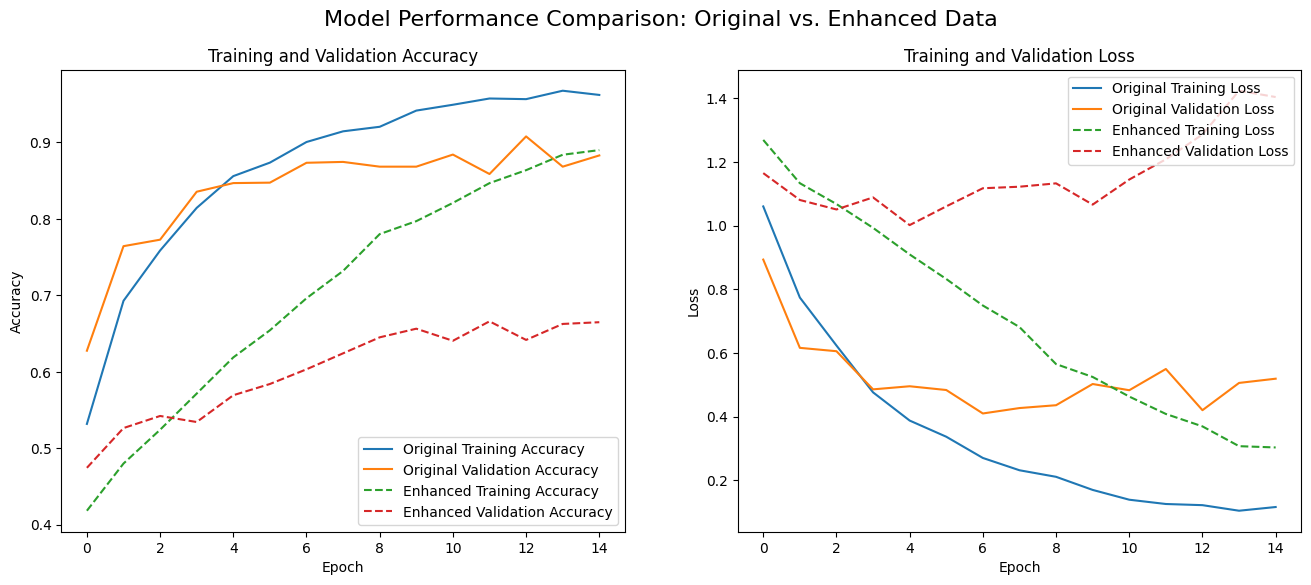



--- FINAL ACCURACY COMPARISON ---
Validation Accuracy (Original Data): 88.30%
Validation Accuracy (Enhanced Data): 66.48%
-----------------------------------

Interestingly, the original data model performed better.
This can sometimes happen with fewer epochs or if the augmentation is too aggressive.


In [11]:
# Plotting the results for comparison
acc_original = history_original.history['accuracy']
val_acc_original = history_original.history['val_accuracy']

acc_enhanced = history_enhanced.history['accuracy']
val_acc_enhanced = history_enhanced.history['val_accuracy']

loss_original_hist = history_original.history['loss']
val_loss_original_hist = history_original.history['val_loss']

loss_enhanced_hist = history_enhanced.history['loss']
val_loss_enhanced_hist = history_enhanced.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_original, label='Original Training Accuracy')
plt.plot(epochs_range, val_acc_original, label='Original Validation Accuracy')
plt.plot(epochs_range, acc_enhanced, label='Enhanced Training Accuracy', linestyle='--')
plt.plot(epochs_range, val_acc_enhanced, label='Enhanced Validation Accuracy', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_original_hist, label='Original Training Loss')
plt.plot(epochs_range, val_loss_original_hist, label='Original Validation Loss')
plt.plot(epochs_range, loss_enhanced_hist, label='Enhanced Training Loss', linestyle='--')
plt.plot(epochs_range, val_loss_enhanced_hist, label='Enhanced Validation Loss', linestyle='--')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.suptitle('Model Performance Comparison: Original vs. Enhanced Data', fontsize=16)
plt.show()


# Final Comparison
print("\n\n--- FINAL ACCURACY COMPARISON ---")
print(f"Validation Accuracy (Original Data): {accuracy_original * 100:.2f}%")
print(f"Validation Accuracy (Enhanced Data): {accuracy_enhanced * 100:.2f}%")
print("-----------------------------------")

if accuracy_enhanced > accuracy_original:
    print("\nAs expected, the model trained on ENHANCED data performed better!")
    print("This is because data augmentation helps the model generalize and reduces overfitting.")
else:
    print("\nInterestingly, the original data model performed better.")
    print("This can sometimes happen with fewer epochs or if the augmentation is too aggressive.")

